# 循环神经网络
- 这个网络要考虑数据以前的状态，把上一次的输出要作为本次的输入
- 如果把上面这一点去掉的话，这个网络就会退化成一个MLP
- 实际生产环境中，一般用GRU，LSTM替代RNN。由于RNN的梯度消失问题，一般在学术上才讨论RNN
- 循环神经网络的伪代码
```python
# t时刻的状态
state_t = 0
# 遍历整个输入
for input_t in input_sequence:
    # 计算输出
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    # 更新状态
    state_t = output_t
```

## 使用numpy实现循环神经网络

In [5]:
# 简单RNN使用numpy实现
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
# state_t.shape
W  = np.random.random((output_features, input_features))
U  = np.random.random((output_features, output_features))
b  = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    # 记录本次的输出，作为下一次的输入
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)
print(final_output_sequence.shape)
final_output_sequence

(6400,)


array([0.99999955, 1.        , 0.99999948, ..., 1.        , 1.        ,
       1.        ])

# 使用keras实现循环神经网络
- 与numpy简单的实现不同，keras可以批量处理数据，所有输入是一个3D张量: (batch_size, timesteps, input_dim)
- 输出有两种方式可以选择，一种是输出每个时间步长的完整序列: (batch_size, timesteps, output_dim)；另一种是输出每个输入序列的输出: (batch_size, output_dim)

In [7]:
from keras.layers import Embedding, SimpleRNN
from keras.models import Sequential
# 每个时间步长的输出
model_time = Sequential()
model_time.add(Embedding(10000, 32))
model_time.add(SimpleRNN(32))
model_time.summary()
print('-'*50)
# 每个输入序列的输出
model_all = Sequential()
model_all.add(Embedding(10000, 32))
# 注意这里用return_sequences=True来控制是否输出整个序列
model_all.add(SimpleRNN(32, return_sequences=True))
model_all.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                         

# 在IMDB数据集上使用RNN
- 在第三章中直接在imdb上使用CNN，将输入看成是10000个特征的无序数据得到的精度大致在88%左右
- 在这个小型RNN中的精度只有85%，并没有表现的太好
  - 一方面原因在于CNN看到的是10000个特征，而RNN只能看到一个500个特征
  - 另一个方面SimpleRNN并不删除处理文本这种长序列，在长序列中，LSTM和GRN要比SimpleRNN更好

In [8]:
model_imdb = Sequential()
model_imdb.add(Embedding(10000, 32))
model_imdb.add(SimpleRNN(32, return_sequences=True))
model_imdb.add(SimpleRNN(32, return_sequences=True))
model_imdb.add(SimpleRNN(32, return_sequences=True))
# 在最后一步输出整个输入序列即可，不在考虑时间的步长
model_imdb.add(SimpleRNN(32))
model_imdb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# 原始的数据形状是(25000, )，需要转换成(25000, maxlen)
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print(input_train.shape, input_test.shape)

(25000, 500) (25000, 500)


In [10]:
# 训练模型
from keras.layers import Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 40s 243ms/step - loss: 0.6391 - acc: 0.6176 - val_loss: 0.5539 - val_acc: 0.7222
Epoch 2/10
157/157 [==============================] - 37s 233ms/step - loss: 0.3913 - acc: 0.8349 - val_loss: 0.4164 - val_acc: 0.8030
Epoch 3/10
157/157 [==============================] - 36s 226ms/step - loss: 0.2849 - acc: 0.8862 - val_loss: 0.3634 - val_acc: 0.8384
Epoch 4/10
157/157 [==============================] - 39s 247ms/step - loss: 0.2376 - acc: 0.9071 - val_loss: 0.4006 - val_acc: 0.8256
Epoch 5/10
157/157 [==============================] - 40s 252ms/step - loss: 0.1854 - acc: 0.9316 - val_loss: 0.4731 - val_acc: 0.7840
Epoch 6/10
157/157 [==============================] - 37s 238ms/step - loss: 0.1340 - acc: 0.9523 - val_loss: 0.5408 - val_acc: 0.7698
Epoch 7/10
157/157 [==============================] - 44s 282ms/step - loss: 0.0926 - acc: 0.9689 - val_loss: 0.4928 - val_acc: 0.8510
Epoch 8/10
157/157 [==============================] - 3

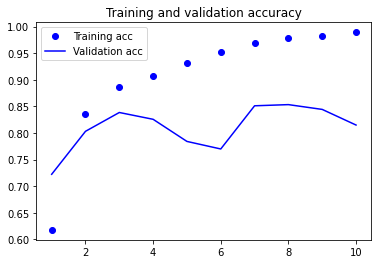

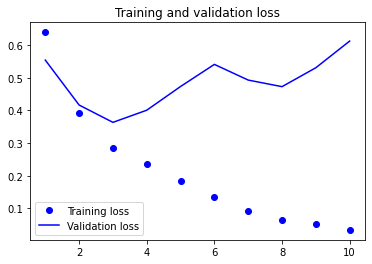

In [11]:
# 绘制训练过程中的损失和准确率
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()